In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
grid_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'compressed_shuffle_cancer_type',
    'gene'
).resolve()

grid_unimodal_results_dir = Path(
    cfg.results_dirs['mutation'],
    'methylation_results_shuffle_cancer_type',
    'gene'
)

bayes_opt_results_dir = Path(
    cfg.results_dirs['multimodal'],
    'bayes_opt',
    'gene'
).resolve()

In [3]:
# load raw data
grid_results_df = au.load_stratified_prediction_results(grid_results_dir, 'gene')

# drop TET2 for now
grid_results_df = grid_results_df[~(grid_results_df.identifier == 'TET2')]
grid_results_df['param_opt'] = 'grid'

# make sure that we have data for all data types and for two replicates (random seeds)
print(grid_results_df.shape)
print(grid_results_df.seed.unique())
print(grid_results_df.identifier.unique())
print(grid_results_df.training_data.unique())
grid_results_df.head()

(1152, 10)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression.me_450k' 'expression.me_27k' 'me_27k.me_450k'
 'expression.me_27k.me_450k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.94104,0.91808,TP53,expression.me_450k,signal,42,train,0,gene,grid
1,0.91608,0.88448,TP53,expression.me_450k,signal,42,test,0,gene,grid
2,0.86899,0.82254,TP53,expression.me_450k,signal,42,cv,0,gene,grid
3,0.94074,0.92014,TP53,expression.me_450k,signal,42,train,1,gene,grid
4,0.90890,0.87164,TP53,expression.me_450k,signal,42,test,1,gene,grid


In [4]:
# load expression and me_27k results
u_results_df = au.load_compressed_prediction_results(grid_unimodal_results_dir, 'gene')
genes = grid_results_df.identifier.unique()
u_results_df = u_results_df[(u_results_df.n_dims == 5000) &
                            (u_results_df.identifier.isin(genes))].copy()
u_results_df.drop(columns='n_dims', inplace=True)
u_results_df['param_opt'] = 'grid'

# make sure data loaded matches our expectations
print(u_results_df.shape)
print(u_results_df.seed.unique())
print(u_results_df.identifier.unique())
print(u_results_df.training_data.unique())
u_results_df.head()

(864, 10)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['me_450k' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.67430,0.61164,TP53,me_450k,shuffled,42,train,0,gene,grid
1,0.69702,0.65328,TP53,me_450k,shuffled,42,test,0,gene,grid
2,0.64787,0.60351,TP53,me_450k,shuffled,42,cv,0,gene,grid
3,0.85622,0.83101,TP53,me_450k,shuffled,42,train,1,gene,grid
4,0.70971,0.66264,TP53,me_450k,shuffled,42,test,1,gene,grid


In [5]:
grid_results_df = pd.concat((
    grid_results_df, u_results_df
))
group_df = (grid_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,experiment,param_opt
identifier,training_data,,,,,,,,
EGFR,expression,48,48,48,48,48,48,48,48


In [6]:
# load raw data
bayes_opt_results_df = au.load_stratified_prediction_results(
    bayes_opt_results_dir, 'gene')

bayes_opt_results_df = bayes_opt_results_df[~(bayes_opt_results_df.training_data.isin(['expression']))].copy()
bayes_opt_results_df['param_opt'] = 'bayes'

# make sure that we have data for all data types and for two replicates (random seeds)
print(bayes_opt_results_df.shape)
print(bayes_opt_results_df.seed.unique())
print(bayes_opt_results_df.identifier.unique())
print(bayes_opt_results_df.training_data.unique())
bayes_opt_results_df.head()

(1152, 10)
[42  1]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['me_27k.me_450k' 'expression.me_450k' 'expression.me_27k.me_450k'
 'expression.me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.95177,0.93953,TP53,me_27k.me_450k,signal,42,train,3,gene,bayes
1,0.89305,0.86989,TP53,me_27k.me_450k,signal,42,test,3,gene,bayes
2,0.85636,0.81911,TP53,me_27k.me_450k,signal,42,cv,3,gene,bayes
0,0.71489,0.66364,TP53,expression.me_450k,shuffled,42,train,2,gene,bayes
1,0.69660,0.63484,TP53,expression.me_450k,shuffled,42,test,2,gene,bayes


In [7]:
# load expression and me_27k results
bayes_u_results_df = au.load_compressed_prediction_results(
    bayes_opt_results_dir, 'gene')

# filter to genes/dims we're using here
bayes_u_results_df = bayes_u_results_df[
    (bayes_u_results_df.n_dims == 5000) &
    (bayes_u_results_df.identifier.isin(genes))
].copy()
bayes_u_results_df.drop(columns='n_dims', inplace=True)
bayes_u_results_df['param_opt'] = 'bayes'

# make sure data loaded matches our expectations
print(bayes_u_results_df.shape)
print(bayes_u_results_df.seed.unique())
print(bayes_u_results_df.identifier.unique())
print(bayes_u_results_df.training_data.unique())
bayes_u_results_df.head()

(864, 10)
[ 1 42]
['TP53' 'EGFR' 'IDH1' 'PIK3CA' 'SETD2' 'KRAS']
['expression' 'me_450k' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.98456,0.97992,TP53,expression,signal,1,train,3,gene,bayes
1,0.91262,0.87397,TP53,expression,signal,1,test,3,gene,bayes
2,0.91328,0.87102,TP53,expression,signal,1,cv,3,gene,bayes
0,0.73019,0.69145,TP53,expression,shuffled,42,train,3,gene,bayes
1,0.68574,0.64732,TP53,expression,shuffled,42,test,3,gene,bayes


In [8]:
bayes_opt_results_df = pd.concat((
    bayes_opt_results_df, bayes_u_results_df
))
group_df = (bayes_opt_results_df
    .groupby(['identifier', 'training_data'])
    .count()
)

# all of these should come up as duplicates (so only one row will print)
# if not, there are either missing folds or duplicated folds
group_df[~group_df.duplicated()].head(10)

,,auroc,aupr,signal,seed,data_type,fold,experiment,param_opt
identifier,training_data,,,,,,,,
EGFR,expression,48,48,48,48,48,48,48,48


In [9]:
results_df = pd.concat((
    grid_results_df, bayes_opt_results_df
))

print(results_df.shape)
results_df.head()

(4032, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,param_opt
0,0.94104,0.91808,TP53,expression.me_450k,signal,42,train,0,gene,grid
1,0.91608,0.88448,TP53,expression.me_450k,signal,42,test,0,gene,grid
2,0.86899,0.82254,TP53,expression.me_450k,signal,42,cv,0,gene,grid
3,0.94074,0.92014,TP53,expression.me_450k,signal,42,train,1,gene,grid
4,0.90890,0.87164,TP53,expression.me_450k,signal,42,test,1,gene,grid


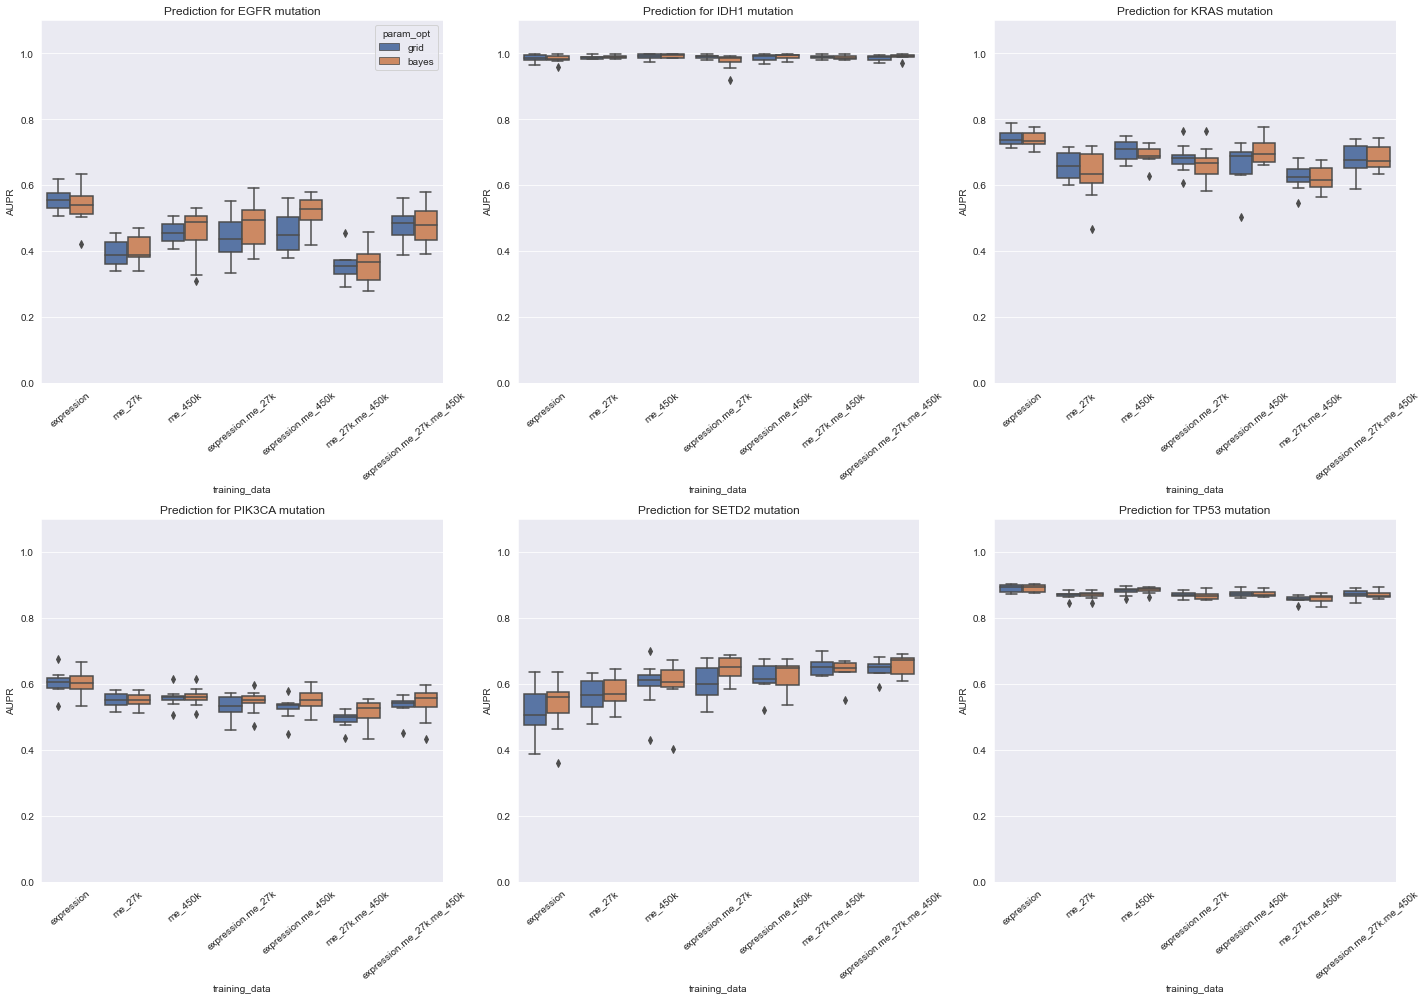

In [10]:
# each subplot will show results for one gene
sns.set({'figure.figsize': (20, 14)})
fig, axarr = plt.subplots(2, 3)
results_df.sort_values(by=['identifier', 'signal', 'training_data'], inplace=True)

data_order =['expression',
             'me_27k',
             'me_450k',
             'expression.me_27k',
             'expression.me_450k',
             'me_27k.me_450k',
             'expression.me_27k.me_450k']

for ix, gene in enumerate(results_df.identifier.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.identifier == gene) &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
    sns.boxplot(data=plot_df, x='training_data', y='aupr',
                order=data_order, hue='param_opt', ax=ax)
    ax.set_title('Prediction for {} mutation'.format(gene))
    ax.set_ylabel('AUPR')
    ax.set_ylim(0.0, 1.1)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
    if ix != 0:
        ax.legend_.remove()
        
plt.tight_layout()